# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [244]:
# Libraries for data load and data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Libraries for feature reduction and clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Libraries for data modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Libraries for performance tuning and model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix

# Magic word for producing visualizations in notebook
%matplotlib inline

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=',')

c:\users\chloe\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1. Data analysis and visualization

In [3]:
# To check the number of rows and columns
print('Azdias file: ', azdias.shape)

Azdias file:  (891221, 366)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
nullseries = ((azdias.isnull().sum()/azdias.shape[0]) * 100).sort_values(ascending=False)
#nullseries = nullseries[nullseries > 30] # Filter columns with more than 30% of data missing
nullseries[:10]

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_LOTTO                      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
dtype: float64

Text(0.5, 1.0, 'Missing data in percentage')

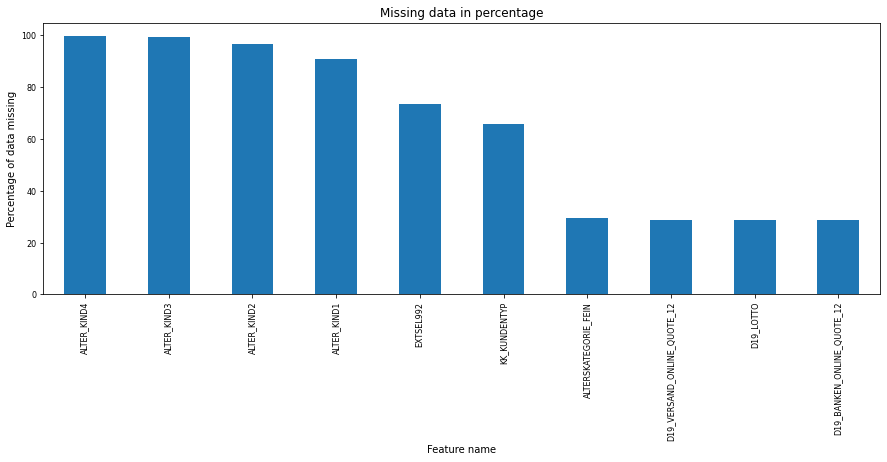

In [6]:
nullseries[:10].plot(kind='bar', figsize=(15,5), fontsize=8)
plt.xlabel('Feature name')
plt.ylabel('Percentage of data missing')
plt.title('Missing data in percentage')

In [7]:
# Number of unique values in columns
uniq = azdias.apply(lambda col: col.nunique()).sort_values(ascending=False)
uniq_20 = uniq[:20] # Subset the top 20 columns with maximum number of unique values
uniq_20

LNR                           891221
EINGEFUEGT_AM                   5162
KBA13_ANZAHL_PKW                1261
ANZ_HAUSHALTE_AKTIV              292
ANZ_STATISTISCHE_HAUSHALTE       268
GEBURTSJAHR                      117
EXTSEL992                         56
VERDICHTUNGSRAUM                  46
CAMEO_DEU_2015                    45
CAMEO_INTL_2015                   43
LP_LEBENSPHASE_FEIN               41
EINGEZOGENAM_HH_JAHR              37
D19_LETZTER_KAUF_BRANCHE          35
MIN_GEBAEUDEJAHR                  32
ANZ_PERSONEN                      30
ALTERSKATEGORIE_FEIN              26
ALTER_HH                          22
ANZ_HH_TITEL                      21
CAMEO_DEUG_2015                   19
ALTER_KIND2                       17
dtype: int64

In [8]:
pd.set_option('display.max_columns', None)
azdias[uniq_20.index].head(10) 

,LNR,EINGEFUEGT_AM,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,GEBURTSJAHR,EXTSEL992,VERDICHTUNGSRAUM,CAMEO_DEU_2015,CAMEO_INTL_2015,LP_LEBENSPHASE_FEIN,EINGEZOGENAM_HH_JAHR,D19_LETZTER_KAUF_BRANCHE,MIN_GEBAEUDEJAHR,ANZ_PERSONEN,ALTERSKATEGORIE_FEIN,ALTER_HH,ANZ_HH_TITEL,CAMEO_DEUG_2015,ALTER_KIND2
0,910215,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,910220,10-02-1992 00:00,963.0,11.0,12.0,1996,NaN,0.0,8A,51.0,21.0,2004.0,NaN,1992.0,2.0,21.0,0.0,0.0,8.0,NaN
2,910225,12-02-1992 00:00,712.0,10.0,7.0,1979,14.0,1.0,4C,24.0,3.0,2000.0,D19_UNBEKANNT,1992.0,1.0,17.0,17.0,0.0,4.0,NaN
3,910226,21-04-1997 00:00,596.0,1.0,2.0,1957,31.0,0.0,2A,12.0,0.0,1998.0,D19_UNBEKANNT,1997.0,0.0,13.0,13.0,0.0,2.0,NaN
4,910241,12-02-1992 00:00,435.0,3.0,3.0,1963,NaN,1.0,6B,43.0,32.0,2004.0,D19_SCHUHE,1992.0,4.0,14.0,20.0,0.0,6.0,NaN
5,910244,12-02-1992 00:00,1300.0,5.0,2.0,1943,20.0,0.0,8C,54.0,8.0,1994.0,D19_ENERGIE,1992.0,1.0,10.0,10.0,0.0,8.0,NaN
6,910248,12-02-1992 00:00,867.0,4.0,3.0,0,NaN,35.0,4A,22.0,2.0,2005.0,D19_UNBEKANNT,1992.0,1.0,NaN,0.0,0.0,4.0,NaN
7,910261,10-02-1992 00:00,758.0,6.0,5.0,1964,NaN,3.0,2D,14.0,5.0,2007.0,D19_UNBEKANNT,1992.0,1.0,14.0,14.0,0.0,2.0,NaN
8,645145,10-02-1992 00:00,511.0,2.0,2.0,1974,NaN,7.0,1A,13.0,10.0,2009.0,NaN,1992.0,1.0,16.0,16.0,1.0,1.0,NaN
9,645153,10-02-1992 00:00,530.0,9.0,7.0,1975,56.0,23.0,1E,15.0,4.0,2016.0,D19_KOSMETIK,1992.0,1.0,17.0,17.0,0.0,1.0,NaN


**Columns that look redundant:** 
    
* LNR -  Is an ID column 

* EINGEFUEGT_AM - A date column

* GEBURTSJAHR - A year column

* EINGEZOGENAM_HH_JAHR - A year column

* D19_LETZTER_KAUF_BRANCHE - Column with feature names

* MIN_GEBAEUDEJAHR - A year column

#### Missing values in rows

c:\users\chloe\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


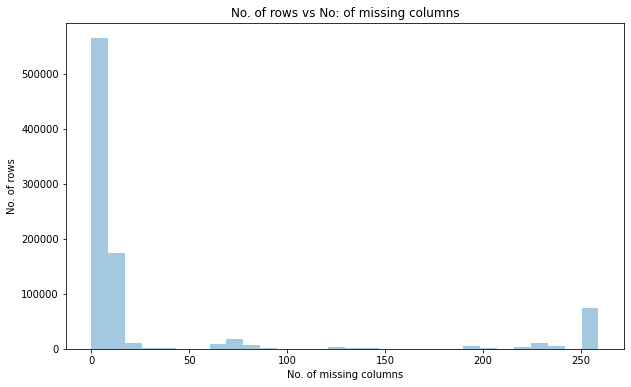

In [9]:
bins = 30
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)
ax.set_title("No. of rows vs No: of missing columns")
ax.set_xlabel("No. of missing columns")
ax.set_ylabel("No. of rows")
sns.distplot(azdias.isnull().sum(axis=1), bins, kde=False)
plt.show()

If a row has more than 50% of data missing, it can be dropped.

## 2. Data preprocessing

### Handling 'unknown's

In [10]:
# Load attributes in DIAS Attributes - Values 2017 file
attribute_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', engine='openpyxl')
attribute_info = attribute_info.fillna(method='ffill') #Forward fill the cells with the previous value
attribute_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


Retrieve all the columns which has a mapping for "unknown" values. This needs to be replaced with NaNs.

In [11]:
# Subset for unknowns from DIAS Attributes - Values 2017.xlsx data
attribute_info = attribute_info[(attribute_info['Meaning'].str.contains('unknown'))] 
attribute_info['Value'].unique()

array([-1, '-1, 0', 0, '-1, 9', '-1'], dtype=object)

In [12]:
# Columns where -1 should be replaced by NaNs
unknown_neg_1 = list(attribute_info[(attribute_info['Value'] == -1)]['Attribute'].values)
unknown_neg_1.append(attribute_info[(attribute_info['Value'] == '-1')]['Attribute'].values)

# Columns where 0 should be replaced by NaNs
unknown_0 = list(attribute_info[(attribute_info['Value'] == 0)]['Attribute'].values)

# Columns where -1 or 9 should be replaced by NaNs
unknown_neg_1_or_9 = list(attribute_info[(attribute_info['Value'] == '-1, 9')]['Attribute'].values)

# Columns where -1 or 0 should be replaced by NaNs
unknown_neg_1_or_0 = list(attribute_info[(attribute_info['Value'] == '-1, 0')]['Attribute'].values)

In [13]:
# Reselect all the columns in azdias
azdias_cols = azdias.columns

# Replace unknowns with NaNs
for col in azdias_cols:
    if col in unknown_neg_1:
        azdias[col] = azdias[col].replace(-1, np.NaN)
    elif col in unknown_0:
        azdias[col] = azdias[col].replace(0, np.NaN)
    elif col in unknown_neg_1_or_9:
        azdias[col] = azdias[col].replace(-1, np.NaN)
        azdias[col] = azdias[col].replace(9, np.NaN)
    elif col in unknown_neg_1_or_0:
        azdias[col] = azdias[col].replace(-1, np.NaN)
        azdias[col] = azdias[col].replace(0, np.NaN)

#### Drop missing data - columnwise

In [14]:
nullseries = ((azdias.isnull().sum()/azdias.shape[0]) * 100).sort_values(ascending=False)
missing_data_cols = list(nullseries[nullseries > 30].index.values)
missing_data_cols

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'ALTER_HH']

Drop columns which have more than 30% of data missing.

In [15]:
azdias.drop(missing_data_cols, axis=1,inplace=True)

In [16]:
azdias.shape

(891221, 356)

#### Drop redundant columns

In [17]:
redundant_cols = ['LNR', 'EINGEFUEGT_AM', 'GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR', 'D19_LETZTER_KAUF_BRANCHE']
azdias.drop(redundant_cols, axis=1,inplace=True)

In [18]:
azdias.shape

(891221, 350)

In [19]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 350 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(85), object(4)
memory usage: 2.3+ GB


#### Drop missing data row-wise

Drop rows with more than 50% of data missing.

In [20]:
threshold = int(azdias.shape[1]/2)
threshold

175

In [21]:
print('Azdias before {}'.format(azdias.shape))

Azdias before (891221, 350)


In [22]:
azdias = azdias.dropna(axis=0, thresh=threshold)

In [23]:
print('Azdias after {}'.format(azdias.shape))

Azdias after (791252, 350)


### Categorical columns

* LP_FAMILIE_GROB and LP_FAMILIE_FEIN are conveying the same information. LP_FAMILIE_GROB can be dropped as the other one is more detailed.
* LP_STATUS_GROB and LP_STATUS_FEIN are conveying the same information. LP_STATUS_GROB can be dropped as the other one is detailed.
* LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN are conveying the same information. LP_LEBENSPHASE_FEIN has too many unique values and so can be dropped.
* CAMEO_DEUG_2015 and CAMEO_DEU_2015 are similar. Since CAMEO_DEU_2015 is more detailed, CAMEO_DEUG_2015 can be dropped.

In [26]:
#azdias_copy = azdias.copy()

In [27]:
import gc
gc.collect()

469

In [28]:
categorical_cols_to_drop = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'LP_LEBENSPHASE_FEIN', 'CAMEO_DEUG_2015']
azdias.drop(categorical_cols_to_drop, axis=1, inplace=True)

In [29]:
categorical_cols = [
    #'AGER_TYP',
    'ANREDE_KZ',
    'CAMEO_DEU_2015',
    #'CAMEO_DEUG_2015',    
    'CJT_GESAMTTYP',    
    'GEBAEUDETYP',
    'GFK_URLAUBERTYP',
    'GEBAEUDETYP_RASTER',
    'GREEN_AVANTGARDE',
    'HEALTH_TYP',
    'LP_FAMILIE_FEIN',
    #'LP_FAMILIE_GROB',
    'LP_STATUS_FEIN',
    #'LP_STATUS_GROB',
    'LP_LEBENSPHASE_GROB',
    # 'LP_LEBENSPHASE_FEIN',
    'NATIONALITAET_KZ',
    'RETOURTYP_BK_S',
    'SHOPPER_TYP',
    #'TITEL_KZ',
    'VERS_TYP',
    'ZABEOTYP',
    'OST_WEST_KZ',
    'DSL_FLAG',
    'HH_DELTA_FLAG',
    'SOHO_KZ',
    'UNGLEICHENN_FLAG'
]

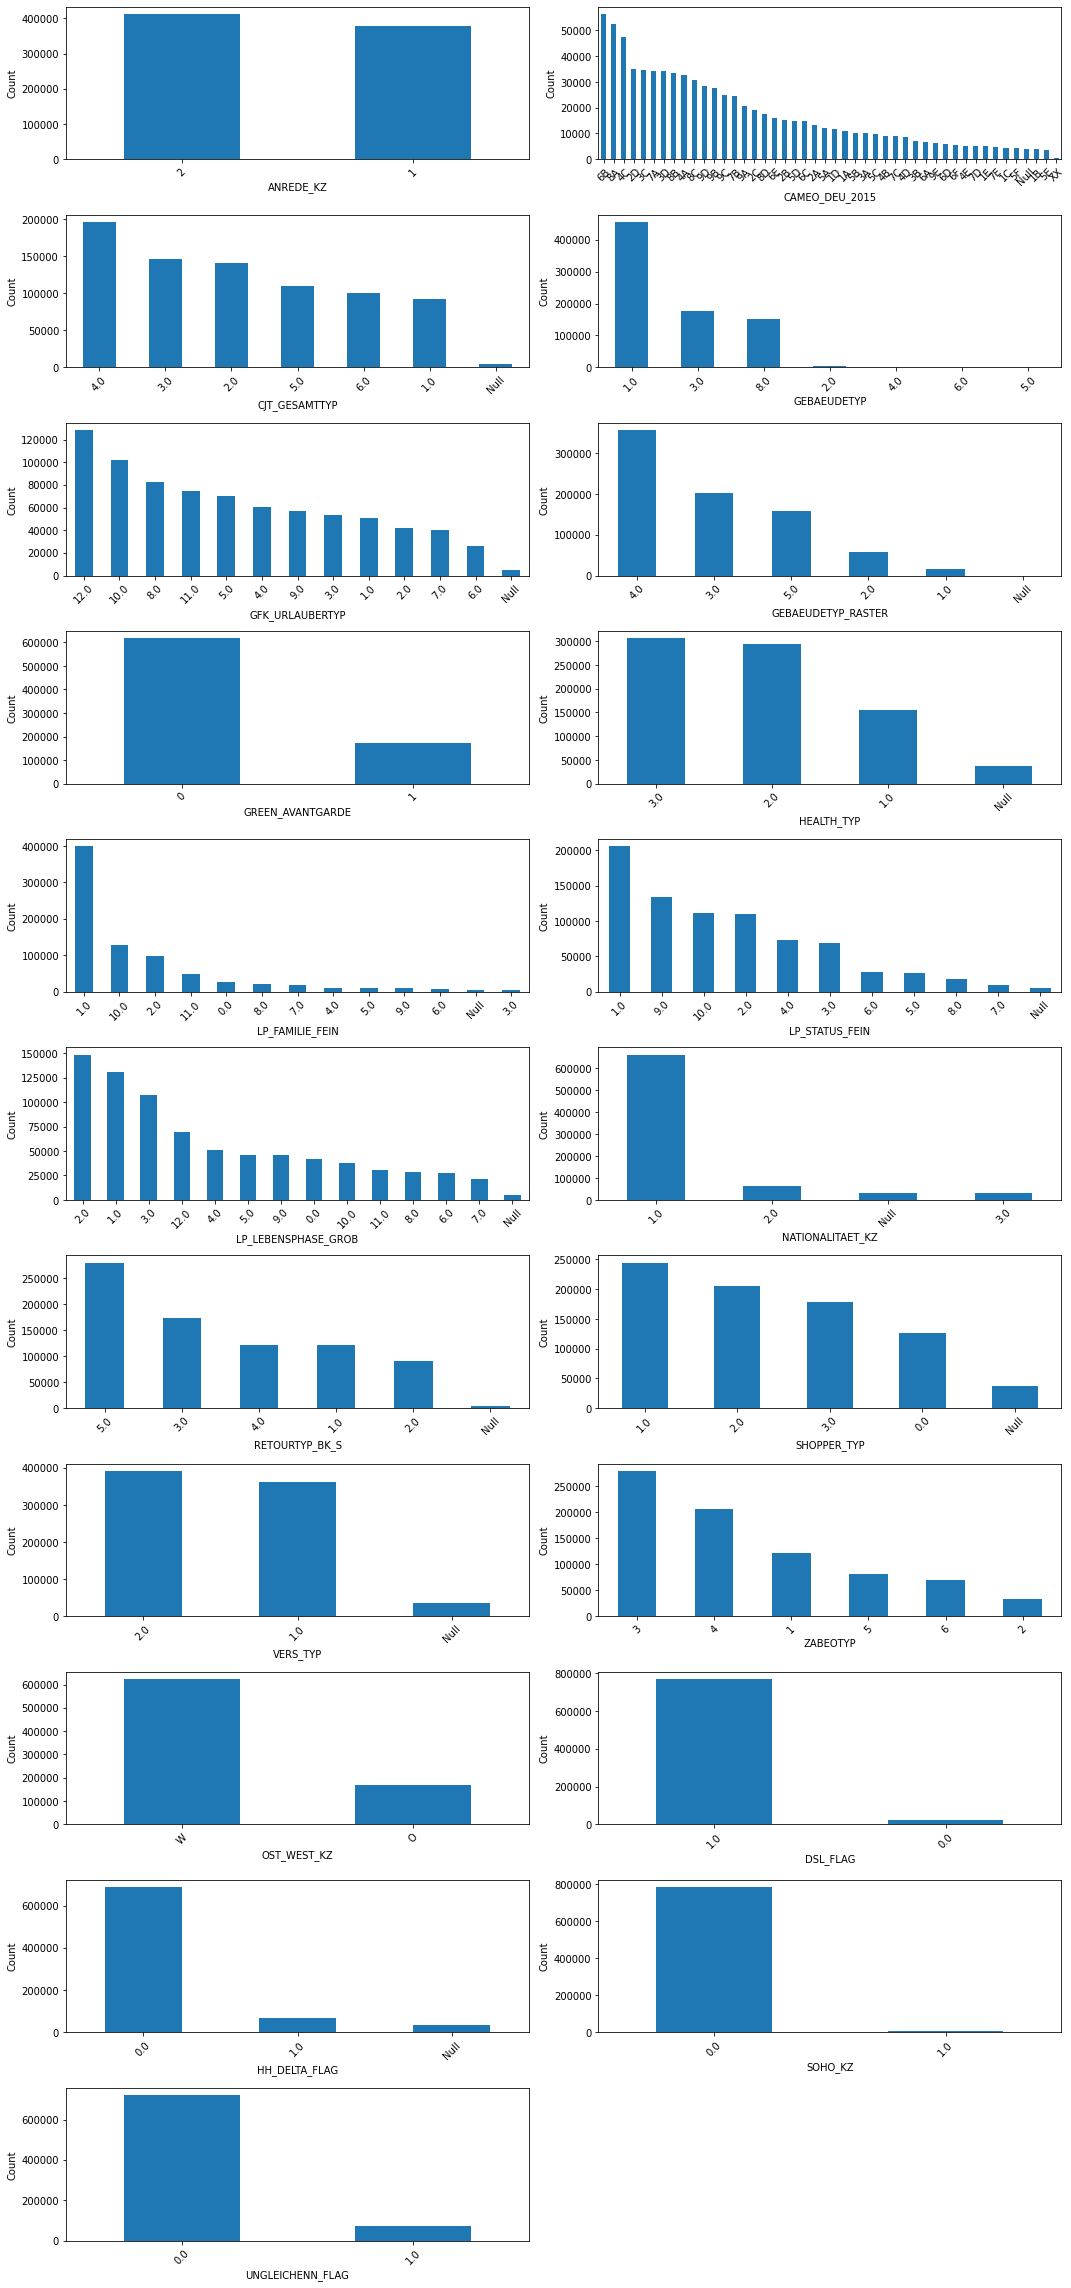

In [30]:
# Create a temporary dataframe where Nulls can be replaced with 'Null' for categorical variables. This will enable plotting.
temp_azdias = azdias[categorical_cols].copy()

# Plot all the categorical variables
n=1
plt.figure(figsize=(15,40))
for col in categorical_cols:
    plt.subplot(14,2,n)
    temp_azdias[col] = temp_azdias[col].fillna('Null')
    temp_azdias[col].value_counts().plot(kind='bar');
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation = 45)
    n += 1
plt.tight_layout()
plt.show()

In [31]:
del temp_azdias

In [32]:
# Replace 'X' and 'XX' in the categorical columns with np.NaN as X and XX represent Nulls
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace('XX', np.NaN)
#azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.NaN)

In [33]:
# Replace NaNs with mode
for col in categorical_cols:
    azdias[col].fillna(azdias[col].mode()[0], inplace=True)

In [34]:
# Check again for nulls
azdias[categorical_cols].isnull().sum()

ANREDE_KZ              0
CAMEO_DEU_2015         0
CJT_GESAMTTYP          0
GEBAEUDETYP            0
GFK_URLAUBERTYP        0
GEBAEUDETYP_RASTER     0
GREEN_AVANTGARDE       0
HEALTH_TYP             0
LP_FAMILIE_FEIN        0
LP_STATUS_FEIN         0
LP_LEBENSPHASE_GROB    0
NATIONALITAET_KZ       0
RETOURTYP_BK_S         0
SHOPPER_TYP            0
VERS_TYP               0
ZABEOTYP               0
OST_WEST_KZ            0
DSL_FLAG               0
HH_DELTA_FLAG          0
SOHO_KZ                0
UNGLEICHENN_FLAG       0
dtype: int64

In [35]:
# Convert all floats to int
for col in categorical_cols:
    if azdias[col].dtypes == 'float':
        azdias[col] = azdias[col].astype(int)

In [36]:
# Convert all categorical columns to string
for col in categorical_cols:
        azdias[col] = azdias[col].astype(str)

In [37]:
azdias[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791252 entries, 1 to 891220
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ANREDE_KZ            791252 non-null  object
 1   CAMEO_DEU_2015       791252 non-null  object
 2   CJT_GESAMTTYP        791252 non-null  object
 3   GEBAEUDETYP          791252 non-null  object
 4   GFK_URLAUBERTYP      791252 non-null  object
 5   GEBAEUDETYP_RASTER   791252 non-null  object
 6   GREEN_AVANTGARDE     791252 non-null  object
 7   HEALTH_TYP           791252 non-null  object
 8   LP_FAMILIE_FEIN      791252 non-null  object
 9   LP_STATUS_FEIN       791252 non-null  object
 10  LP_LEBENSPHASE_GROB  791252 non-null  object
 11  NATIONALITAET_KZ     791252 non-null  object
 12  RETOURTYP_BK_S       791252 non-null  object
 13  SHOPPER_TYP          791252 non-null  object
 14  VERS_TYP             791252 non-null  object
 15  ZABEOTYP             791252 non-nu

### Dummy variable creation for categorical variables

In [38]:
print('Azdias shape before {} '.format(azdias.shape))

Azdias shape before (791252, 346) 


In [39]:
# Create dummies for all the categorical columns and drop the original columns
dummies_df = pd.get_dummies(azdias[categorical_cols], drop_first=True) 
print('Dummies shape {} '.format(dummies_df.shape))

Dummies shape (791252, 125) 


In [40]:
dummies_df.head()

,ANREDE_KZ_2,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_8,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GEBAEUDETYP_RASTER_2,GEBAEUDETYP_RASTER_3,GEBAEUDETYP_RASTER_4,GEBAEUDETYP_RASTER_5,GREEN_AVANTGARDE_1,HEALTH_TYP_2,HEALTH_TYP_3,LP_FAMILIE_FEIN_1,LP_FAMILIE_FEIN_10,LP_FAMILIE_FEIN_11,LP_FAMILIE_FEIN_2,LP_FAMILIE_FEIN_3,LP_FAMILIE_FEIN_4,LP_FAMILIE_FEIN_5,LP_FAMILIE_FEIN_6,LP_FAMILIE_FEIN_7,LP_FAMILIE_FEIN_8,LP_FAMILIE_FEIN_9,LP_STATUS_FEIN_10,LP_STATUS_FEIN_2,LP_STATUS_FEIN_3,LP_STATUS_FEIN_4,LP_STATUS_FEIN_5,LP_STATUS_FEIN_6,LP_STATUS_FEIN_7,LP_STATUS_FEIN_8,LP_STATUS_FEIN_9,LP_LEBENSPHASE_GROB_1,LP_LEBENSPHASE_GROB_10,LP_LEBENSPHASE_GROB_11,LP_LEBENSPHASE_GROB_12,LP_LEBENSPHASE_GROB_2,LP_LEBENSPHASE_GROB_3,LP_LEBENSPHASE_GROB_4,LP_LEBENSPHASE_GROB_5,LP_LEBENSPHASE_GROB_6,LP_LEBENSPHASE_GROB_7,LP_LEBENSPHASE_GROB_8,LP_LEBENSPHASE_GROB_9,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,RETOURTYP_BK_S_2,RETOURTYP_BK_S_3,RETOURTYP_BK_S_4,RETOURTYP_BK_S_5,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_2,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,OST_WEST_KZ_W,DSL_FLAG_1,HH_DELTA_FLAG_1,SOHO_KZ_1,UNGLEICHENN_FLAG_1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0


In [41]:
azdias.drop(categorical_cols, axis=1, inplace=True)

In [42]:
print('Azdias shape after {} '.format(azdias.shape))

Azdias shape after (791252, 325) 


### Check correlation between numerical features

In [43]:
import gc
gc.collect()

60

In [44]:
# Select all the columns present in azdias file as numeric
numerical_cols = azdias._get_numeric_data().columns
numerical_cols

Index(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       ...
       'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ALTERSKATEGORIE_GROB'],
      dtype='object', length=324)

In [45]:
numeric_data = azdias[numerical_cols]

In [46]:
# Create correlation matrix to get the correlation between the numerical columns
corr_matrix = numeric_data.corr().abs()

In [47]:
# Reference: https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

# Identify columns with correlation greater than 0.7.
high_corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

<ipython-input-47-9f6386804fce>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


In [48]:
print('Number of columns to drop: {}'.format(len(high_corr_cols)))

Number of columns to drop: 95


In [49]:
# Drop the highly correlated columns
azdias.drop(to_drop, axis=1, inplace=True) 
azdias.shape

(791252, 230)

### Numerical columns

In [50]:
numerical_cols = [
    'ANZ_HAUSHALTE_AKTIV',
    'ANZ_HH_TITEL',
    'ANZ_PERSONEN',
    'ANZ_TITEL',
    'CAMEO_INTL_2015',
    'KBA13_ANZAHL_PKW',
    'VERDICHTUNGSRAUM'
]

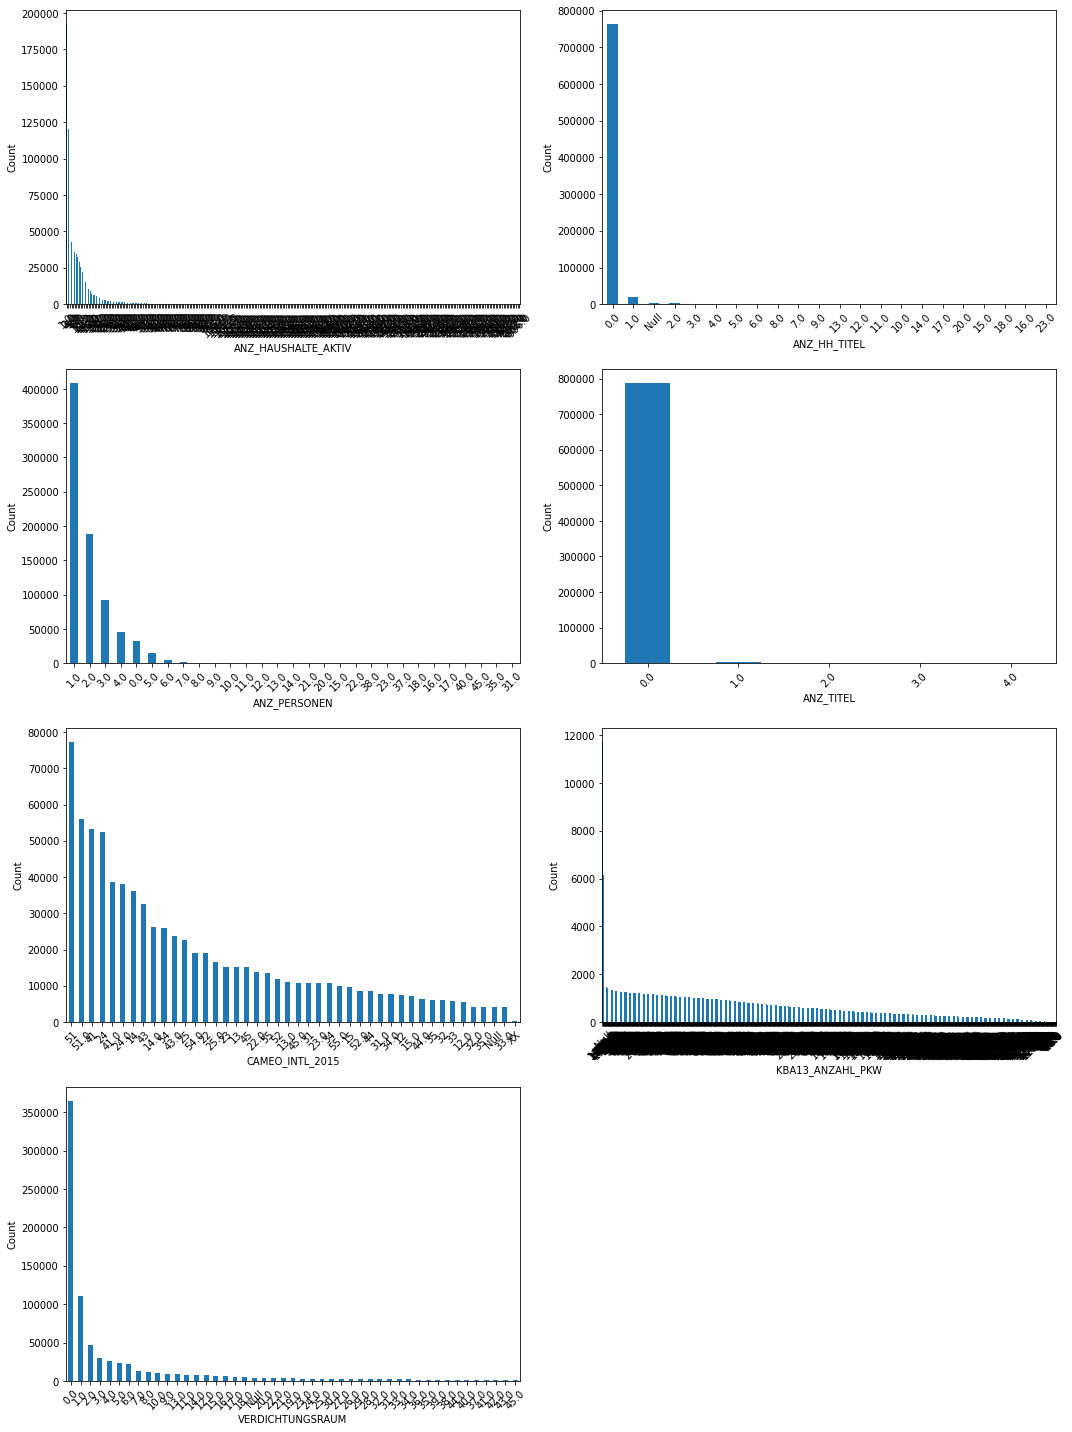

In [52]:
# Create a temporary dataframe where Nulls can be replaced with 'Null' for categorical variables. This will enable plotting.
temp_azdias = azdias[numerical_cols].copy()

# Plot all the categorical variables
n=1
plt.figure(figsize=(15,20))
for col in numerical_cols:
    plt.subplot(4,2,n)
    temp_azdias[col] = temp_azdias[col].fillna('Null')
    temp_azdias[col].value_counts().plot(kind='bar');
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation = 45)
    n += 1
plt.tight_layout()
plt.show()

In [53]:
del temp_azdias

In [54]:
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.NaN)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

#### Outlier treatment for numerical variables

Almost all the numerical columns are highly skewed and hence we need to perform an outlier treatment.

In [55]:
# Outlier treatment using IQR method

def outlier_treatment(df, columns):
    '''
    This function will remove outliers from a given dataset.
    It calculates Q1 and Q3 as the first and third quantiles respectively.
    IQR is calculated as the difference between Q3 and Q1.
    Lower limit for a column = Q1  1.5 IQR
    Upper limit for a column = Q3 + 1.5 IQR
    If any values are found greater than the upper limit, it will be replaced with the upper limit.
    If any values are found lower than the lower limit, it will be replaced with the lower limit.
    Returns a dataframe without any outliers for the columns given as input.
    '''
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        
        df[col] = np.where(df[col] <lower_limit, lower_limit, df[col])
        df[col] = np.where(df[col] >upper_limit, upper_limit, df[col])
        
    return df

In [56]:
# If the column has skewness more than 1 or less than -1, outlier treatment needs to be done
skewed_cols = []
for col in numerical_cols:
    skewness = azdias[col].skew()    
    if (skewness > 1) or (skewness < -1):
        skewed_cols.append(col)
        print(col, ': ', skewness)         

ANZ_HAUSHALTE_AKTIV :  8.786093994124291
ANZ_HH_TITEL :  22.744000311133057
ANZ_PERSONEN :  1.8666950378368916
ANZ_TITEL :  18.241932125138398
KBA13_ANZAHL_PKW :  1.2630938794528623
VERDICHTUNGSRAUM :  2.5313778258111648


In [57]:
#azdias_copy = azdias.copy()

In [58]:
# Apply IQR method for highly skewed columns
azdias = outlier_treatment(azdias, skewed_cols)   

In [59]:
for col in skewed_cols:
    skewness = azdias[col].skew()    
    if (skewness > 1) or (skewness < -1):
        print(col, ': ', skewness)        

ANZ_HAUSHALTE_AKTIV :  1.31819045856508
VERDICHTUNGSRAUM :  1.2455902728562354


In [60]:
azdias[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791252 entries, 1 to 891220
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  791252 non-null  float64
 1   ANZ_HH_TITEL         787504 non-null  float64
 2   ANZ_PERSONEN         791252 non-null  float64
 3   ANZ_TITEL            791252 non-null  float64
 4   CAMEO_INTL_2015      786774 non-null  float64
 5   KBA13_ANZAHL_PKW     785421 non-null  float64
 6   VERDICHTUNGSRAUM     787150 non-null  float64
dtypes: float64(7)
memory usage: 48.3 MB


In [61]:
# Replace NaNs with mean
for col in numerical_cols:    
    azdias[col].fillna((azdias[col].mean()), inplace=True)

In [62]:
# Check for nulls again
azdias[numerical_cols].isnull().sum()

ANZ_HAUSHALTE_AKTIV    0
ANZ_HH_TITEL           0
ANZ_PERSONEN           0
ANZ_TITEL              0
CAMEO_INTL_2015        0
KBA13_ANZAHL_PKW       0
VERDICHTUNGSRAUM       0
dtype: int64

### Ordinal columns

In [63]:
azdias_cols = azdias.columns
ordinal_cols = []
for col in azdias_cols:
    if (col not in numerical_cols) and (col not in categorical_cols):
        ordinal_cols.append(col)

In [64]:
azdias[ordinal_cols].isnull().sum()

AKT_DAT_KL                   0
ALTERSKATEGORIE_FEIN    182082
ANZ_KINDER                   0
ARBEIT                    4044
BALLRAUM                   577
                         ...  
VHA                          0
VHN                      24699
W_KEIT_KIND_HH           58801
WOHNDAUER_2008               0
WOHNLAGE                     0
Length: 223, dtype: int64

In [65]:
# Replace NaNs with median
for col in ordinal_cols:
    azdias[col].fillna((azdias[col].median()), inplace=True)

In [66]:
((azdias.isnull().sum()/azdias.shape[0]) * 100).sort_values(ascending=False)

AKT_DAT_KL            0.0
KBA13_CCM_2501        0.0
KBA13_CCM_3001        0.0
KBA13_FAB_ASIEN       0.0
KBA13_FAB_SONSTIGE    0.0
                     ... 
KBA05_FRAU            0.0
KBA05_GBZ             0.0
KBA05_HERST1          0.0
KBA05_HERST2          0.0
WOHNLAGE              0.0
Length: 230, dtype: float64

In [67]:
print('Azdias {}'.format(azdias.shape))
print('Dummies {}'.format(dummies_df.shape))

Azdias (791252, 230)
Dummies (791252, 125)


#### Combine numerical data and dummy data

In [68]:
# Concatenate dummy and original dataframe
azdias_clean = pd.concat([azdias, dummies_df], axis=1)
azdias_clean.shape

(791252, 355)

In [69]:
# Scale the data using StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean)

In [70]:
azdias_scaled.shape

(791252, 355)

## 3. Dimensionality reduction

In [71]:
pca = PCA().fit(azdias_scaled)

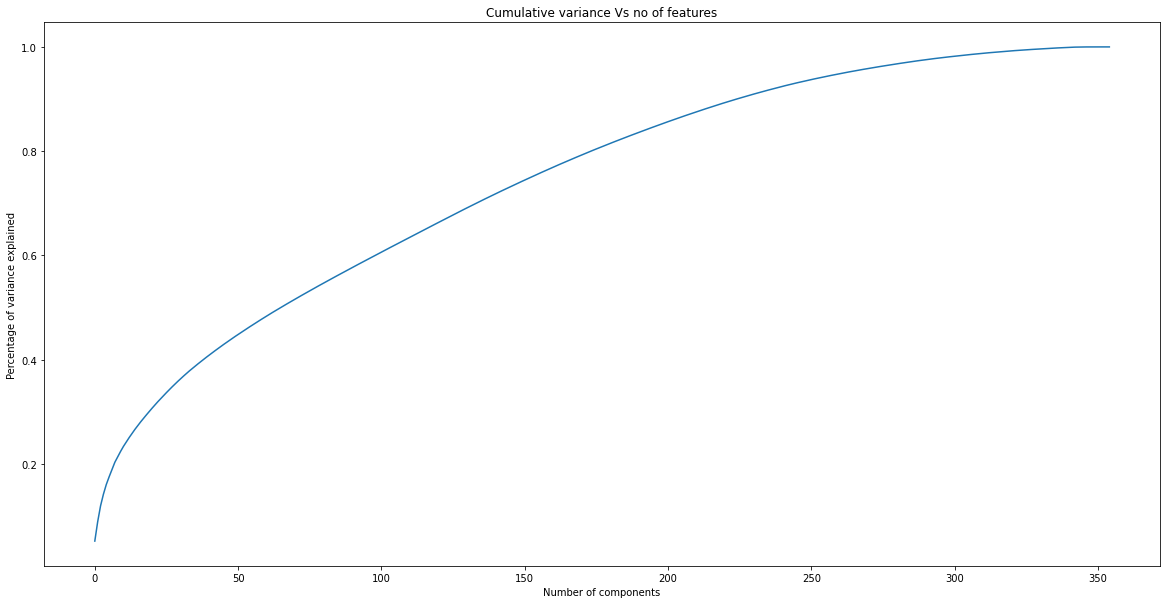

In [72]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Percentage of variance explained')
plt.title('Cumulative variance Vs no of features')
plt.show()

In [73]:
for i in np.arange(250, 300, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

250 components explain 0.9360913094601424 of variance.
260 components explain 0.9475912015739651 of variance.
270 components explain 0.9577582779933023 of variance.
280 components explain 0.9667544384164551 of variance.
290 components explain 0.97477291851811 of variance.


95% of the variance in the data can be explained by 270 features. So I'm going to keep 270 features for this project.

In [74]:
pca = PCA(n_components=270)
azdias_pca = pca.fit_transform(azdias_scaled)

#### Understanding the PCA components

While we have chosen 270 components, we will take at the first 2 components and see the weightage given to each variable.

In [75]:
def pca_results(df, pca, component_no, features_no):
    '''
    This function will plot the top 5 most positive features for a given PCA component.
    
    '''
    
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pca_comp.head(features_no)
    #pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    #if show_plot:
    # Plot the result
    pca_comp.plot(kind='bar', 
                  title='Top {} weighted features for PCA component {}'.format(features_no, component_no),
                  figsize=(8, 5), color=['green', 'blue', 'orange', 'pink', 'grey', 'red'])
    plt.show()
    
    return pca_comp

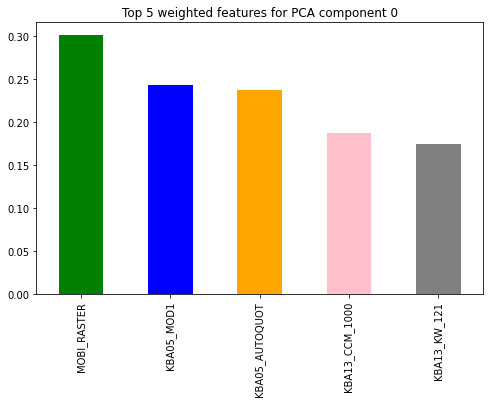

MOBI_RASTER       0.3008
KBA05_MOD1        0.2431
KBA05_AUTOQUOT    0.2371
KBA13_CCM_1000    0.1866
KBA13_KW_121      0.1749
Name: 269, dtype: float64


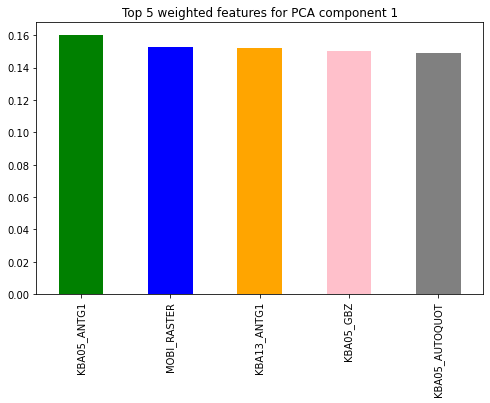

KBA05_ANTG1       0.1600
MOBI_RASTER       0.1527
KBA13_ANTG1       0.1518
KBA05_GBZ         0.1501
KBA05_AUTOQUOT    0.1489
Name: 0, dtype: float64


In [76]:
# Check the varaibel weightage given for the first 2 PCA components.
# We will use azdias_new as input as azdias_scaled is an array without any column names
# This will plot the top 5 features of each component
for i in range(0, 2, 1):
    result = pca_results(azdias_clean, pca, i, 5)
    print(result)

**First principal component:**

Positively associated with:

* MOBI_RASTER : Description not found
* KBA05_MOD1: Share of upper class cars
* KBA05_AUTOQUOT: Share of cars per household
* KBA13_CCM_1000: Share of cars with less than 1000ccm
* KBA13_KW_121: Share of cars with an engine power more than 120 KW

**Second principal component:**

Positively associated with:

* KBA05_ANTG1          : Number of 1-2 family houses in the cell
* MOBI_RASTER          : Description not found
* KBA13_ANTG1          : Description not found
* KBA05_GBZ            : Number of buildings in the microcell
* KBA05_AUTOQUOT       : Share of cars per household

In [77]:
import gc
gc.collect()

3034

# Part 1: Customer Segmentation Report

## 4. Clustering

Use Kmeans clustering on the cleaned data to find the clusters.

In [78]:
def kmeans_sse_calculation(data):
    '''
    This function calculates the sum of squared errors (SSE) for various values of clusters
    '''
    # Create a dicstionary to store the number of clusters and the corresponding SSE calcualted
    sse = {}
    for k in range(1,11):
        # Instantiate the kmeans model with various cluster numbers (k)
        kmeans = KMeans(n_clusters=k)
        
        # Fit the model
        model = kmeans.fit(data)        
        
        sse[k] = model.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        
    return sse

In [79]:
# Calculate SSEs for clusters ranging from 1 to 10 for the azdias pca data
sse = kmeans_sse_calculation(azdias_pca)

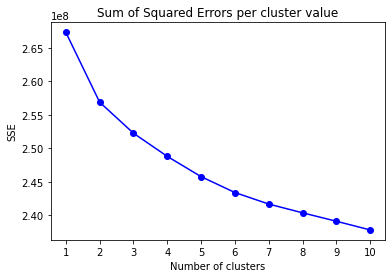

In [80]:
plt.figure()
x = list(sse.keys())
y = list(sse.values())
plt.plot(x, y, marker='o', color='b')
plt.xticks(range(1,11))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors per cluster value')
plt.show()

There is no clear elbow in this plot. For this project, I will choose clusters=7.

In [81]:
#### Create the selected number of clusters for the general population (azdias dataset) and make cluster predictions

In [82]:
k = 7
kmeans = KMeans(k, random_state=40, n_jobs=-1).fit(azdias_pca)
population_clusters = kmeans.predict(azdias_pca)

c:\users\chloe\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


## 5. Repeat the steps on customer dataset

In [85]:
gc.collect()

2834

In [123]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')

In [124]:
print('Customers file: ', customers.shape)

Customers file:  (191652, 369)


In [263]:
def data_preprocessing(df, missing_data_cols, redundant_cols, high_corr_cols, categorical_cols_to_drop, categorical_cols, numerical_cols, ordinal_cols, unknown_neg_1, unknown_0, unknown_neg_1_or_9, unknown_neg_1_or_0, cust=True, clustering=True):
    '''
    This function will perform all the data cleaning steps on the customers dataset, which was done on df dataset.
    '''
    
    if cust==True:
        # Drop the extra columns present in customer data
        df.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)
    
    # Select all the columns in df
    df_cols = df.columns

    # Replace unknowns with NaNs
    for col in df_cols:
        if col in unknown_neg_1:
            df[col] = df[col].replace(-1, np.NaN)
        elif col in unknown_0:
            df[col] = df[col].replace(0, np.NaN)
        elif col in unknown_neg_1_or_9:
            df[col] = df[col].replace(-1, np.NaN)
            df[col] = df[col].replace(9, np.NaN)
        elif col in unknown_neg_1_or_0:
            df[col] = df[col].replace(-1, np.NaN)
            df[col] = df[col].replace(0, np.NaN)

    df.drop(missing_data_cols, axis=1,inplace=True)
    df.drop(redundant_cols, axis=1,inplace=True)
    
    if clustering==True:
        # Drop missing data rowwise
        threshold = int(df.shape[1]/2)
        df = df.dropna(axis=0, thresh=threshold)

    df.drop(categorical_cols_to_drop, axis=1, inplace=True)

    # Replace 'X' and 'XX' in the categorical columns with np.NaN as X and XX represent Nulls
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.NaN)

    # Replace NaNs with mode
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Convert all floats to int
    for col in categorical_cols:
        if df[col].dtypes == 'float':
            df[col] = df[col].astype(int)

    # Convert all categorical columns to string
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Create dummies for all the categorical columns and drop the original columns
    dummies_df = pd.get_dummies(df[categorical_cols], drop_first=True) 
    df.drop(categorical_cols, axis=1, inplace=True)

    # Drop the highly correlated columns
    df.drop(high_corr_cols, axis=1, inplace=True) 

    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.NaN)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)

    # If the column has skewness more than 1 or less than -1, outlier treatment needs to be done
    skewed_cols = []
    for col in numerical_cols:
        skewness = df[col].skew()    
        if (skewness > 1) or (skewness < -1):
            skewed_cols.append(col)

    # Apply IQR method for highly skewed columns
    df = outlier_treatment(df, skewed_cols)   

    # Replace NaNs with mean
    for col in numerical_cols:    
        df[col].fillna((df[col].mean()), inplace=True)

    # Replace NaNs with median
    for col in ordinal_cols:
        df[col].fillna((df[col].median()), inplace=True)

    # Concatenate dummy and original dataframe
    df_clean = pd.concat([df, dummies_df], axis=1)
    
    return df_clean

In [155]:
customers_clean_data = data_preprocessing(customers, missing_data_cols, redundant_cols, high_corr_cols, categorical_cols_to_drop, categorical_cols, numerical_cols, ordinal_cols, unknown_neg_1, unknown_0, unknown_neg_1_or_9, unknown_neg_1_or_0, cust=True, clustering=True)

TypeError: customer_data_cleaning() got an unexpected keyword argument 'cust'

In [127]:
customers_clean_data.shape

(140866, 354)

In [128]:
azdias_clean.shape

(791252, 355)

In [129]:
az = azdias_clean.columns # All columns in Azdias clean data
cust = customers_clean_data.columns # All columns in customer clean data

In [131]:
# Columns found in azdias clean dataset but not in customers cleaned dataset
diff_cols = [col for col in az if col not in cust]
diff_cols

['GEBAEUDETYP_5']

In [132]:
# Add a dummy column with 0s for the missing columns
customers_clean_data['GEBAEUDETYP_5'] = 0

In [133]:
customers_clean_data.shape

(140866, 355)

In [134]:
# Scale the data using StandardScaler
scaler = StandardScaler()
customers_data_scaled = scaler.fit_transform(customers_clean_data)

In [135]:
customers_pca = pca.transform(customers_data_scaled)

In [136]:
# Cluster predictions for the customers
customers_clusters  = kmeans.predict(customers_pca)

### Cluster summary for general population and customers

In [83]:
def cluster_summary(df):
    '''
    This function creates a dataframe with cluster, 
    number of people assigned to each cluster in absolute number and percentage of the total population.
    '''
    cluster = pd.Series(df).value_counts().index
    population = pd.Series(df).value_counts().values
    clusters = pd.DataFrame({'cluster': cluster, 'population': population})
    clusters['percentage'] = clusters['population'].apply(lambda x: (x/clusters['population'].sum()) * 100)
    
    return clusters

In [84]:
cluster_summary_gen_population = cluster_summary(population_clusters)
cluster_summary_gen_population

,cluster,population,percentage
0,0,136009,17.189088
1,5,126732,16.016642
2,3,124085,15.682109
3,1,119690,15.126660
4,4,107783,13.621830
5,6,89964,11.369829
6,2,86989,10.993843


Majority of the general population is falling under cluster 0.

In [137]:
cluster_summary_customers = cluster_summary(customers_clusters)
cluster_summary_customers

,cluster,population,percentage
0,1,28230,20.040322
1,0,25094,17.814093
2,5,24159,17.150341
3,2,23134,16.422700
4,4,17153,12.176821
5,3,13400,9.512586
6,6,9696,6.883137


20% the customers are falling in cluster 1. This is where majority of the customers are.

In [138]:
clusters_combined = cluster_summary_gen_population.merge(cluster_summary_customers, how='inner', on='cluster')
clusters_combined = clusters_combined.rename(columns={'population_x': 'count_gen_pop', 'percentage_x': 'percentage_gen_pop', 'population_y': 'count_customers', 'percentage_y': 'percentage_customers'})
clusters_combined['diff_percentage'] = clusters_combined['percentage_customers'] - clusters_combined['percentage_gen_pop']
clusters_combined= clusters_combined.sort_values(by='diff_percentage', ascending=False)
clusters_combined

,cluster,count_gen_pop,percentage_gen_pop,count_customers,percentage_customers,diff_percentage
6,2,86989,10.993843,23134,16.422700,5.428857
3,1,119690,15.126660,28230,20.040322,4.913662
1,5,126732,16.016642,24159,17.150341,1.133699
0,0,136009,17.189088,25094,17.814093,0.625005
4,4,107783,13.621830,17153,12.176821,-1.445009
5,6,89964,11.369829,9696,6.883137,-4.486692
2,3,124085,15.682109,13400,9.512586,-6.169522


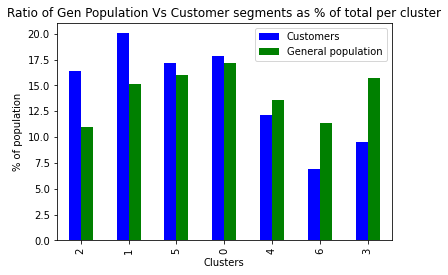

In [139]:
# Compare the number of people in each cluster for general population and customers
clusters_combined.plot(x="cluster", y=["percentage_customers", "percentage_gen_pop"], kind="bar", color=['blue', 'green'])
plt.legend(('Customers', 'General population'),fontsize=10)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.xlabel('Clusters') 
plt.ylabel('% of population')
plt.show()

Analysis of clusters:

* General population is distributed to all the clusters.
* Customers of the mail order company fall mostly under cluster 1.
* Cluster 2 is where difference in the percentage of people is seen between customers and the general population. This cluster can be analysed to understand the characteristics of customers where more people from the general population can be added.

### What kind of people are part of a cluster that is overrepresented in the customer data compared to the general population?

In [140]:
# Top 5 principal components of cluster 2
cluster_center_2 = kmeans.cluster_centers_[2]
cluster_center_2 = pd.Series(cluster_center_2)
cluster_center_2.sort_values(ascending=False, inplace=True)
cluster_center_2.head(5)

1    5.923616
0    2.071583
3    0.971281
4    0.864738
8    0.577528
dtype: float64

It can be seen that PCA 1 is highly positiovely influencing the cluster. Hence we will look at the top 5 and bottom 5 features of PCA 1.

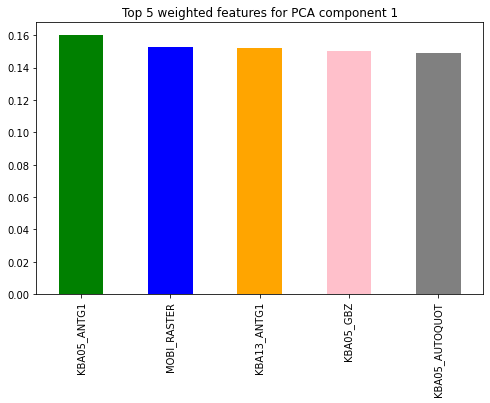

KBA05_ANTG1       0.1600
MOBI_RASTER       0.1527
KBA13_ANTG1       0.1518
KBA05_GBZ         0.1501
KBA05_AUTOQUOT    0.1489
Name: 0, dtype: float64

In [141]:
pca_results(customers_clean_data, pca, 1, 5)

Cluster 1 of customers mainly consists of people with the below features:

* KBA05_ANTG1       : Number of 1-2 family houses in the cell
* MOBI_RASTER       : Description not found
* KBA13_ANTG1       : Description not found
* KBA05_GBZ         : Number of buildings in the microcell
* KBA05_AUTOQUOT    : Share of cars per household

# Part 2: Supervised Learning Model

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [264]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=',')

In [265]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [266]:
mailout_train.shape

(42962, 367)

(array([42430.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   532.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

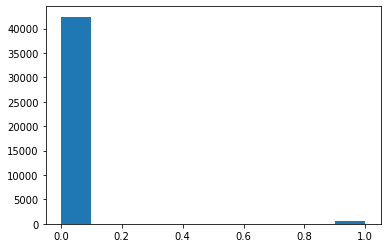

In [267]:
plt.hist(mailout_train['RESPONSE'])

This is a very highly imbalanced dataset. Out of 42,962 rows, less than 2500 fall under response=1 category.

In [268]:
# Run the data through the data_preprocessing to perform the data cleaning steps
train_clean = data_preprocessing(mailout_train, missing_data_cols, redundant_cols, high_corr_cols, categorical_cols_to_drop, categorical_cols, numerical_cols, ordinal_cols, unknown_neg_1, unknown_0, unknown_neg_1_or_9, unknown_neg_1_or_0, cust=False, clustering=False)

In [269]:
train_clean.shape

(42962, 355)

In [270]:
((train_clean.isnull().sum()/train_clean.shape[0]) * 100).sort_values(ascending=False) # Check for any nulls

AKT_DAT_KL            0.0
CAMEO_DEU_2015_8A     0.0
CAMEO_DEU_2015_3C     0.0
CAMEO_DEU_2015_3B     0.0
CAMEO_DEU_2015_3A     0.0
                     ... 
KBA05_VORB2           0.0
KBA05_VORB1           0.0
KBA05_VORB0           0.0
KBA05_SEG8            0.0
UNGLEICHENN_FLAG_1    0.0
Length: 355, dtype: float64

In [271]:
X = train_clean.drop('RESPONSE',axis=1)
y = train_clean['RESPONSE']

In [304]:
# Split the dataset into Train/Validation/Test

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

As we can see, the model is unable to classify the class 1 properly due to the highly imabalanced training data. We will try out other models to improve the F1 score and get a better classification done.

In [360]:
SEED = 42

models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

In [361]:
# Train using various models and store the evaluation metrics in a dictionary
model_results = {'Model':[],
                  'ROC':[]
                }

for model_name, model in models:
    
    model = model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(y_test, y_pred) 
    
    model_results["Model"].append(model_name)
    model_results["ROC"].append(roc_score)

[20:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [362]:
results = pd.DataFrame.from_dict(model_results, orient='index').transpose()
results = results.sort_values(by=['ROC'], ascending=[False])
results

,Model,ROC
4,XGBClassifier,0.719714
3,AdaBoostClassifier,0.718857
0,LogisticRegression,0.678797
2,RandomForestClassifier,0.538025
1,DecisionTreeClassifier,0.520128


XGBoost Classifier is giving the highest ROC and hence we will chose that as our final model.

### Hyper parameter tuning for XGBoost Classifier

In [365]:
gc.collect()

1817

In [366]:
param_grid = {'max_depth': [5,10],
              'learning_rate': [0.01],
              'gamma':[0.1,0.5,1.0],
              'n_estimators':[100, 200]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                                n_jobs=-1, 
                                                                eval_metric="auc",
                                                                silent=1,
                                                                random_state=42), 
                           param_grid = param_grid, 
                           scoring = "roc_auc",
                           cv = 5, 
                           n_jobs = -1, 
                           verbose=2)

In [367]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[22:54:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, silent=1,
        

In [368]:
# Best estimator 
best_xgb = xgb_grid.best_estimator_

In [369]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.7522277504236933
Best Params:  {'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [370]:
predictions_xgb = best_xgb.predict_proba(X_test)[:,1]

In [371]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_test, predictions_xgb)))

ROC score on validation data: 0.7541


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [373]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv')

In [374]:
mailout_test.shape

(42833, 366)

In [375]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [376]:
test_LNR = mailout_test['LNR']

In [377]:
# Run the data through the data_preprocessing to perform the data cleaning steps
test_clean = data_preprocessing(mailout_test, missing_data_cols, redundant_cols, high_corr_cols, categorical_cols_to_drop, categorical_cols, numerical_cols, ordinal_cols, unknown_neg_1, unknown_0, unknown_neg_1_or_9, unknown_neg_1_or_0, cust=False, clustering=False)

In [378]:
test_clean.shape

(42833, 354)

### Make predictions on the test dataset

In [379]:
kaggle_predictions = best_xgb.predict_proba(test_clean)[:,1]

In [380]:
kaggle_predictions

array([0.20428243, 0.20428243, 0.18556932, ..., 0.20229   , 0.20792995,
       0.20428243], dtype=float32)

In [381]:
df_kaggle = pd.DataFrame(index=test_LNR, data=kaggle_predictions)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)
df_kaggle

,RESPONSE
LNR,
1754,0.204282
1770,0.204282
1465,0.185569
1470,0.185569
1478,0.185569
...,...
67615,0.191322
67938,0.185534
67942,0.202290


In [382]:
df_kaggle.to_csv("kaggle_submission.csv")